In [4]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#Setting up Data
import tensorflow as tf
from sklearn import preprocessing
import tensorflow as tf
import os
os.environ['CUDA_VISIBLE_DEVICES']='0' 
tf.reset_default_graph()
%matplotlib inline

In [5]:
#中冷后进气压力/进气量/ 中冷后进气温度/冷却水温度/ EGR阀开度/实测氧浓度/实测碳烟排放
data = pd.read_csv("data.csv")
data.head()
print(data.shape)

(149503, 7)


In [6]:
#删除97000--100000范围的数据
data['soot'][97000:100000] = -1
data_la = data[data['soot'] != -1]

In [7]:
#data = data_la.drop(data_la[(data_la['soot']<0.2)].index)
#f = lambda x : 20 if x>20 else x
#data2 = data['soot'].map(f)
data_la['soot'] = data_la['soot'].apply( lambda x: 0.1 if x<0.2 else x)
#data_la['soot'] = data_la['soot'].apply( lambda x: 20 if x>20 else x)
#data = data_la.drop(data_la[(data_la['soot']<0.2)].index)
#data_la['soot'] = data_la['soot'].apply( lambda x: 0.2 if (x < 0.3) & (x >0.1) else x)  
#data_la['soot'] = data_la['soot'].apply( lambda x: 0.15 if x<0.3 else x)

/data/anaconda3/envs/base_py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.



 mu = 1.37 and sigma = 1.20



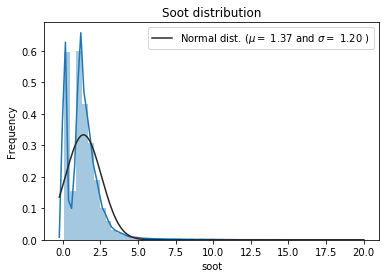

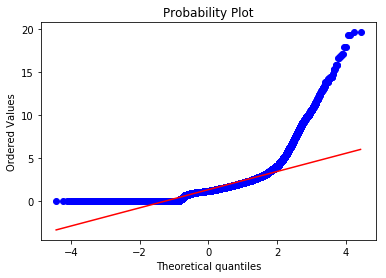

In [8]:
from scipy import stats
from scipy.stats import norm, skew

sns.distplot(data_la['soot'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data_la['soot'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Soot distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data_la['soot'], plot=plt)
plt.show()

/data/anaconda3/envs/base_py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until



 mu = 1.32 and sigma = 1.24



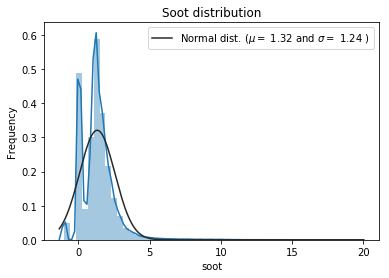

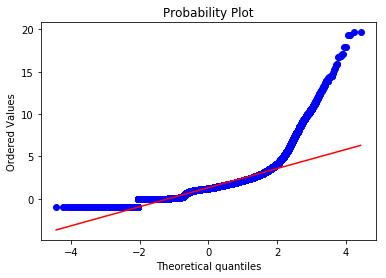

In [9]:
#data = data_la.drop(data_la[(data_la['soot']<0.2)].index)
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
data_la['soot'] = np.log1p(data_la['soot'])

#Check the new distribution 
sns.distplot(data['soot'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data['soot'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Soot distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data['soot'], plot=plt)
plt.show()

In [16]:
data_la.head()

,PIM,AIR_FLOW,THA,THW,LEGR,CEXREAL,soot
0,106.624542,135.911193,35.805401,81.269257,20.968098,22.050871,0.095310
1,106.546928,130.372953,35.846352,81.239487,20.848291,21.919291,0.212689
2,106.422729,141.673937,35.915401,81.264389,21.806496,21.752228,0.212689
3,106.422729,135.911193,35.987576,81.266518,22.175026,21.668766,0.532391
4,106.391685,144.218531,36.077019,81.314468,21.668106,21.549181,0.532391


In [18]:
features =  data_la.columns.values[0:6]   
#data = data_la.drop(data_la[(data_la['soot']<0.2)].index)
data = data_la
x = data[features].values
y = data['soot'].values

In [21]:
print(x.shape,y.shape)

(146503, 6) (146503,)


In [22]:
ss_x = preprocessing.StandardScaler()
train_x = ss_x.fit_transform(x)
ss_y = preprocessing.StandardScaler()
train_y = ss_y.fit_transform(y.reshape(-1,1))  #y--(506,1)

In [24]:
BATCH_START = 0
TIME_STEPS = 100  ## backpropagation through time 的 time_steps
BATCH_SIZE = 30
INPUT_SIZE = 6
OUTPUT_SIZE = 1
CELL_SIZE = 10   #RNN的hidden单元
LR = 0.006

In [25]:
def get_batch_boston():
    global train_x,train_y,BATCH_START,TIME_STEPS
    x_part = train_x[BATCH_START:BATCH_START + BATCH_SIZE * TIME_STEPS]
    y_part = train_y[BATCH_START:BATCH_START + BATCH_SIZE * TIME_STEPS]
    print('Time_period=', BATCH_START, BATCH_START + TIME_STEPS * BATCH_SIZE)
    
    seq = x_part.reshape((BATCH_SIZE,TIME_STEPS,INPUT_SIZE))
    res = y_part.reshape((BATCH_SIZE,TIME_STEPS,OUTPUT_SIZE))
    BATCH_START += TIME_STEPS
    
    return [seq,res] 

In [26]:
class LSTMRNN(object):
    def __init__(self,n_steps,input_size,output_size,cell_size,batch_size):
        self.n_steps = n_steps
        self.input_size = input_size
        self.output_size = output_size
        self.cell_size = cell_size
        self.batch_size = batch_size
        
        with tf.name_scope("inputs"):
            self.xs = tf.placeholder(tf.float32, [None, n_steps, input_size], name='xs')
            self.ys = tf.placeholder(tf.float32, [None, n_steps, output_size], name='ys')
        with tf.variable_scope("in_hidden"):
            self.add_input_layer()
        with tf.variable_scope("LSTM-cell"): 
            self.add_cell()
        with tf.variable_scope("out_hidden"):
            self.add_output_layer()
        with tf.name_scope("cost"):
            self.compute_cost()
        with tf.name_scope("train"):
            self.train_op = tf.train.AdamOptimizer(LR).minimize(self.cost)
    def add_input_layer(self):
        l_in_x = tf.reshape(self.xs, [-1, self.input_size], name='2_2D')
        Ws_in = self._weight_variabe([self.input_size, self.cell_size])
        bs_in = self._biases_variabe([self.cell_size,])
        with tf.name_scope('Wx_plus_b'):
            l_in_y = tf.matmul(l_in_x, Ws_in)+bs_in
        self.l_in_y = tf.reshape(l_in_y, [-1, self.n_steps, self.cell_size], name='2_3D')
        
        #多时刻的状态叠加层
    def add_cell(self):
        lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(self.cell_size, forget_bias=1.0, state_is_tuple=True)
        with tf.name_scope('initial-state'):
            self.cell_init_state = lstm_cell.zero_state(self.batch_size, dtype=tf.float32)
        self.cell_outputs, self.cell_final_state = tf.nn.dynamic_rnn(lstm_cell, self.l_in_y, initial_state=self.cell_init_state, time_major=False)
        
    
    def add_output_layer(self):
        l_out_x = tf.reshape(self.cell_outputs, [-1, self.cell_size], name='2_2D')
        Ws_out = self._weight_variabe([self.cell_size, self.output_size])
        bs_out = self._biases_variabe([self.output_size,])
        with tf.name_scope('Wx_plus_b'):
            self.pred = tf.matmul(l_out_x, Ws_out)+bs_out
    
    #cost函数定义
    def compute_cost(self):
        losses = tf.contrib.legacy_seq2seq.sequence_loss_by_example([tf.reshape(self.pred, [-1], name='reshape_pred')],
        [tf.reshape(self.ys, [-1], name='reshape_target')],[tf.ones([self.batch_size * self.n_steps], dtype=tf.float32)],
        average_across_timesteps=True,softmax_loss_function=self.ms_error,name='losses')
        with tf.name_scope('average_cost'):
            self.cost = tf.div(tf.reduce_sum(losses, name='losses_sum'),self.batch_size,name='average_cost')
            tf.summary.scalar('cost', self.cost)
    
    def ms_error(self, labels, logits):
        return tf.square(tf.subtract(labels,logits))
    
    def _weight_variabe(sef, shape, name='weights'):
        initializer = tf.random_normal_initializer(mean=0., stddev=1.,)
        return tf.get_variable(shape=shape, initializer=initializer, name=name)
    
    def _biases_variabe(sef, shape, name='biases'):
        initializer = tf.constant_initializer(0.1)
        return tf.get_variable(name=name, initializer=initializer, shape=shape)        

In [27]:
seq,res = get_batch_boston()
#tf.reset_default_graph()
model = LSTMRNN(TIME_STEPS, INPUT_SIZE, OUTPUT_SIZE, CELL_SIZE, BATCH_SIZE)
sess = tf.Session()
merged = tf.summary.merge_all()
writer = tf.summary.FileWriter("logs", sess.graph)
sess.run(tf.initialize_all_variables())
for j in range(2000):#训练2000次
        pred_res=None
        for i in range(40):#把整个数据分为40个时间段
            seq, res = get_batch_boston()
 
            if i == 0:
                feed_dict = {
                        model.xs: seq,
                        model.ys: res,
                        # create initial state
                }
            else:
                feed_dict = {
                    model.xs: seq,
                    model.ys: res,
                    model.cell_init_state: state    # use last state as the initial state for this run
                }
            _, cost, state, pred = sess.run([model.train_op, model.cost, model.cell_final_state, model.pred],feed_dict=feed_dict)
            pred_res=pred
  
            result = sess.run(merged, feed_dict)
            writer.add_summary(result, i)
        print('{0} cost: '.format(j ), round(cost, 4))
        BATCH_START=0 #从头再来一遍


Time_period= 0 3000
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
Time_period= 4000 

Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
8 cost:  9.9627
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_pe

Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
17 cost:  6.6075
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_p

Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
26 cost:  5.2185
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_p

Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
35 cost:  4.7701
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_p

Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
44 cost:  4.6014
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_per

Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
53 cost:  4.3641
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_peri

Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
61 cost:  4.1904
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
62 cos

Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
70 cost:  4.0206
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_p

Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
79 cost:  3.8932
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_p

Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
88 cost:  3.8477
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_p

Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
97 cost:  3.7985
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_p

Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
106 cost:  3.6838
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_

Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
115 cost:  3.5474
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_

Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
124 cost:  3.4528
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_

Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
133 cost:  3.3467
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_pe

Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
142 cost:  3.2218
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_per

Time_period= 3900 6900
150 cost:  3.0269
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
151 cost:  3.0001
Time_period= 0 3000
Time_period= 

Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
159 cost:  2.8904
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_

Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
168 cost:  2.8304
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_

Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
177 cost:  2.7624
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_

Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
186 cost:  2.7025
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_

Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
195 cost:  2.6708
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_

Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
204 cost:  2.6415
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_

Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
213 cost:  2.602
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_p

Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
222 cost:  2.5988
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_per

Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
231 cost:  2.6024
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_per

239 cost:  2.5979
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
240 cost:  2.5959
Time_period= 0 3000
Time_period= 100 3100
Time_period= 2

Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
248 cost:  2.6025
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_

Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
257 cost:  2.6065
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_

Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
266 cost:  2.6034
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_

Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
275 cost:  2.5833
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_

Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
284 cost:  2.5614
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_

Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
293 cost:  2.5196
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_

Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
302 cost:  2.4971
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_

Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
311 cost:  2.4775
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_per

Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
320 cost:  2.4951
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_per

Time_period= 3800 6800
Time_period= 3900 6900
328 cost:  2.4507
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
329 cost:  2.4279
Time_perio

Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
337 cost:  2.5096
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_

Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
346 cost:  2.4149
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_

Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
355 cost:  2.4628
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_

Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
364 cost:  2.3753
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_

Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
373 cost:  2.3694
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_

Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
382 cost:  2.3508
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_

Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
391 cost:  2.3301
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_per

Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
400 cost:  2.3222
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_per

Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
408 cost:  2.2893
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
409 c

Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
417 cost:  2.2591
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_

Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
426 cost:  2.2381
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_

Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
435 cost:  2.2294
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_

Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
444 cost:  2.2122
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_

Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
453 cost:  2.1971
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_

Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
462 cost:  2.1889
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_p

Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
471 cost:  2.1815
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_per

Time_period= 3900 6900
479 cost:  2.1944
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
480 cost:  2.1745
Time_period= 0 3000
Time_period= 

Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
488 cost:  2.1712
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_

Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
497 cost:  2.1648
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_

Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
506 cost:  2.1527
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_

Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
515 cost:  2.1379
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_

Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
524 cost:  2.1284
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_

Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
533 cost:  2.117
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_p

Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
542 cost:  2.1224
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_

Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
551 cost:  2.1308
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_per

Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
560 cost:  2.1201
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_per

Time_period= 3800 6800
Time_period= 3900 6900
568 cost:  2.1155
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
569 cost:  2.1169
Time_perio

Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
577 cost:  2.1202
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_

Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
586 cost:  2.1146
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_

Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
595 cost:  2.1173
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_

Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
604 cost:  2.1068
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_

Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
613 cost:  2.157
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_p

Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
622 cost:  2.1148
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_

Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
631 cost:  2.1119
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_per

Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
640 cost:  2.1003
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_per

Time_period= 3800 6800
Time_period= 3900 6900
648 cost:  2.1108
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
649 cost:  2.1128
Time_perio

Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
657 cost:  2.094
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_p

Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
666 cost:  2.105
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_p

Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
675 cost:  2.1145
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_

Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
684 cost:  2.1206
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_

Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
693 cost:  2.0982
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_

Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
702 cost:  2.1517
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_

Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
711 cost:  2.1954
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_p

Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
720 cost:  2.1541
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_per

Time_period= 3800 6800
Time_period= 3900 6900
728 cost:  2.1027
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
729 cost:  2.1113
Time_perio

Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
737 cost:  2.0779
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_

Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
746 cost:  2.0766
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_

Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
755 cost:  2.0626
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_

Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
764 cost:  2.1074
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_

Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
773 cost:  2.0735
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_

Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
782 cost:  2.0357
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_

Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
791 cost:  2.0642
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_per

Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
800 cost:  2.0508
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_per

Time_period= 3900 6900
808 cost:  2.0878
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
809 cost:  2.0678
Time_period= 0 3000
Time_period= 

Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
817 cost:  2.0209
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_

Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
826 cost:  2.0336
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_

Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
835 cost:  2.0355
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_

Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
844 cost:  2.008
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_p

Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
853 cost:  2.0086
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_

Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
862 cost:  2.0474
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_

Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
871 cost:  2.0559
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_per

Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
880 cost:  2.0028
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_per

Time_period= 3900 6900
888 cost:  2.2235
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
889 cost:  2.0749
Time_period= 0 3000
Time_period= 

Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
897 cost:  1.9754
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_

Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
906 cost:  1.9812
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_

Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
915 cost:  1.9958
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_

Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
924 cost:  2.008
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_p

Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
933 cost:  2.1669
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_

Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
942 cost:  2.0035
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_

Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
951 cost:  2.0031
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_

Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
960 cost:  1.9963
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_per

Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
969 cost:  1.9879
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_per

Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
978 cost:  1.9706
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_per

Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
986 cost:  1.9693
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
987 c

Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
995 cost:  1.9858
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_

Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1004 cost:  4.0521
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time

Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1013 cost:  2.0797
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time

Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1022 cost:  2.0581
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time

Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1031 cost:  1.9798
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time

Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1040 cost:  1.9594
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time

Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1049 cost:  2.2153
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_pe

Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1058 cost:  1.9594
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_pe

1066 cost:  1.9529
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1067 cost:  2.0276
Time_period= 0 3000
Time_period= 100 3100
Time_period=

Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1075 cost:  2.0747
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time

Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1084 cost:  1.9714
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time

Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1093 cost:  1.9377
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time

Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1102 cost:  1.9672
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time

Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1111 cost:  1.9636
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time

Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1120 cost:  2.1331
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time

Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1129 cost:  1.9726
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time

Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1138 cost:  1.9547
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_pe

Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1147 cost:  1.9813
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_pe

Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1155 cost:  2.0051
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1156

Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1164 cost:  1.937
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_

Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1173 cost:  1.9633
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time

Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1182 cost:  1.9883
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time

Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1191 cost:  1.9619
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time

Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1200 cost:  1.9554
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time

Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1209 cost:  2.0169
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time

Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1218 cost:  1.9587
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_pe

Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1227 cost:  1.9896
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_pe

1235 cost:  1.9655
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1236 cost:  1.9651
Time_period= 0 3000
Time_period= 100 3100
Time_period=

Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1244 cost:  1.953
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_

Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1253 cost:  1.9806
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time

Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1262 cost:  2.0038
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time

Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1271 cost:  1.9428
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time

Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1280 cost:  1.9422
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time

Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1289 cost:  1.9652
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time

Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1298 cost:  1.9313
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_p

Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1307 cost:  1.9581
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_pe

1315 cost:  1.9277
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1316 cost:  1.9294
Time_period= 0 3000
Time_period= 100 3100
Time_period=

Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1324 cost:  1.9265
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1325

Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1333 cost:  1.9302
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time

Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1342 cost:  2.8409
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time

Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1351 cost:  2.0279
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time

Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1360 cost:  2.0577
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time

Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1369 cost:  2.039
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_

Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1378 cost:  2.0231
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time

Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1387 cost:  1.9897
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_pe

Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1396 cost:  1.9754
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_pe

1404 cost:  2.0322
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1405 cost:  1.9943
Time_period= 0 3000
Time_period= 100 3100
Time_period=

Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1413 cost:  2.0253
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time

Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1422 cost:  1.9743
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time

Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1431 cost:  1.955
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_

Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1440 cost:  1.9479
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time

Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1449 cost:  1.9449
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time

Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1458 cost:  1.9426
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time

Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1467 cost:  2.1607
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_pe

Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1476 cost:  2.0033
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_pe

Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1484 cost:  1.9595
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1485

Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1493 cost:  2.0137
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time

Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1502 cost:  2.0023
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time

Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1511 cost:  1.9473
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time

Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1520 cost:  1.9383
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time

Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1529 cost:  1.9394
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time

Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1538 cost:  1.9344
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_pe

Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1547 cost:  72.7405
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_p

Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1555 cost:  71.397
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1556

Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1564 cost:  67.0149
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Tim

Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1573 cost:  66.9829
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Tim

Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1582 cost:  66.8207
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Tim

Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1591 cost:  66.6983
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Tim

Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1600 cost:  66.5376
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Tim

Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1609 cost:  66.3197
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_p

Time_period= 3900 6900
1617 cost:  66.0426
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1618 cost:  66.0039
Time_period= 0 3000
Time_peri

Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1626 cost:  65.72
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_

Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1635 cost:  65.2888
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Tim

Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1644 cost:  64.8033
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Tim

Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1653 cost:  64.2571
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Tim

Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1662 cost:  63.6704
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Tim

Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1671 cost:  62.4421
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Tim

Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1680 cost:  61.0588
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_p

Time_period= 3900 6900
1688 cost:  59.7362
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1689 cost:  60.0232
Time_period= 0 3000
Time_peri

Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1697 cost:  57.8765
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Tim

Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1706 cost:  53.6535
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Tim

Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1715 cost:  51.2065
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Tim

Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1724 cost:  49.5845
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Tim

Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1733 cost:  47.9442
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Tim

Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1742 cost:  46.4029
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_p

Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1751 cost:  83.8975
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_p

Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1759 cost:  64.286
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1760

Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1768 cost:  62.8869
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Tim

Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1777 cost:  62.6284
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Tim

Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1786 cost:  62.623
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time

Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1795 cost:  62.4842
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Tim

Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1804 cost:  62.4296
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Tim

Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1813 cost:  62.9784
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Tim

Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1822 cost:  62.0122
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_p

Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1831 cost:  61.6717
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_p

Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1839 cost:  60.9083
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Tim

Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1848 cost:  59.519
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time

Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1857 cost:  60.2559
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Tim

Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1866 cost:  59.0641
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Tim

Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1875 cost:  61.2251
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Tim

Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1884 cost:  60.11
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_

Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1893 cost:  59.3915
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Tim

Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1902 cost:  57.4213
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_p

Time_period= 3800 6800
Time_period= 3900 6900
1910 cost:  56.3826
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1911 cost:  56.2156
Time_p

Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1919 cost:  53.4933
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Tim

Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1928 cost:  53.6294
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Tim

Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1937 cost:  53.8138
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Tim

Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1946 cost:  52.4754
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Tim

Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1955 cost:  51.9852
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Tim

Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1964 cost:  51.2831
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_p

Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1973 cost:  50.7709
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_p

Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1981 cost:  51.9882
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
198

Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1990 cost:  49.0186
Time_period= 0 3000
Time_period= 100 3100
Time_period= 200 3200
Time_period= 300 3300
Time_period= 400 3400
Time_period= 500 3500
Time_period= 600 3600
Time_period= 700 3700
Time_period= 800 3800
Time_period= 900 3900
Time_period= 1000 4000
Time_period= 1100 4100
Time_period= 1200 4200
Time_period= 1300 4300
Time_period= 1400 4400
Time_period= 1500 4500
Time_period= 1600 4600
Time_period= 1700 4700
Time_period= 1800 4800
Time_period= 1900 4900
Time_period= 2000 5000
Time_period= 2100 5100
Time_period= 2200 5200
Time_period= 2300 5300
Time_period= 2400 5400
Time_period= 2500 5500
Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Tim

Time_period= 2600 5600
Time_period= 2700 5700
Time_period= 2800 5800
Time_period= 2900 5900
Time_period= 3000 6000
Time_period= 3100 6100
Time_period= 3200 6200
Time_period= 3300 6300
Time_period= 3400 6400
Time_period= 3500 6500
Time_period= 3600 6600
Time_period= 3700 6700
Time_period= 3800 6800
Time_period= 3900 6900
1999 cost:  51.3735


In [ ]:
%matplotlib inline
# 画图
print("结果:",pred_res.shape)
#与最后一次训练所用的数据保持一致
#train_y = train_y[190:490]
#print('实际',train_y.flatten().shape)

r_size=BATCH_SIZE * TIME_STEPS
###画图###########################################################################
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 3))  # dpi参数指定绘图对象的分辨率，即每英寸多少个像素，缺省值为80
axes = fig.add_subplot(1, 1, 1)
#为了方便看，只显示了后100行数据
line1,=axes.plot(range(100), pred.flatten()[-3600:] , 'b--',label='rnn计算结果')
#line2,=axes.plot(range(len(gbr_pridict)), gbr_pridict, 'r--',label='优选参数')
line3,=axes.plot(range(100), train_y.flatten()[-3600:], 'r',label='实际')

axes.grid()
fig.tight_layout()
#plt.legend(handles=[line1, line2,line3])
plt.legend(handles=[line1,  line3])
plt.title('递归神经网络')
plt.show()